In [1]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [2]:
labels = pd.read_csv("rsna_heart_detection.csv")


In [3]:
labels.head()


,label,x0,y0,w,h,name,img_shape_x,img_shape_y
0,heart,91,71,77,102,ca112a3c-b701-48b8-a94f-725ea65416a7,224,224
1,heart,70,64,89,67,e5f292ae-f1e5-497c-b0a0-68f1aa2196b2,224,224
2,heart,82,55,81,76,67af68f7-7ba0-49a0-a373-3a8801eb0faa,224,224
3,heart,93,74,78,89,814289a3-9ce8-4cba-842f-45d6a36f540d,224,224
4,heart,85,61,85,93,e508969f-c931-462b-aa90-ccde34a4d9e5,224,224


In [4]:
ROOT_PATH = Path("stage_2_train_images/")
SAVE_PATH = Path("processed_heart_detection")


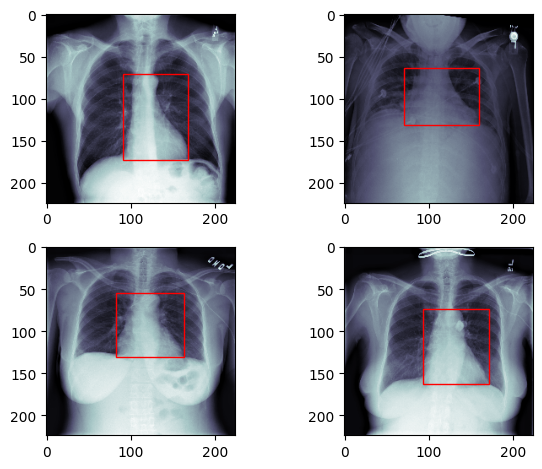

In [6]:
fig, axis = plt.subplots(2, 2)
c = 0
for i in range(2):
    for j in range(2):
        data = labels.iloc[c]  # Get the c-th row of the labels

        patient_id = data["name"]
        dcm_path = ROOT_PATH/str(patient_id)  # Create the path to the dcm file
        dcm_path = dcm_path.with_suffix(".dcm")  # And add the .dcm suffix
        dcm = pydicom.read_file(dcm_path)  # Read the dicom file with pydicom

        # Retrieve the actual image and resize it to match the labels
        dcm_array = dcm.pixel_array
        dcm_array = cv2.resize(dcm_array, (224, 224))

        x = data["x0"]
        y = data["y0"]
        width = data["w"]
        height = data["h"]

        axis[i][j].imshow(dcm_array, cmap="bone")
        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
        axis[i][j].add_patch(rect)

        c+=1
plt.tight_layout()


In [7]:
sums, sums_squared = 0, 0
train_ids = []
val_ids = []

for counter, patient_id in enumerate(list(labels.name)):
    data = labels.iloc[c]  # Get the c-th row of the labels

    patient_id = data["name"]
    dcm_path = ROOT_PATH/str(patient_id)  # Create the path to the dcm file
    dcm_path = dcm_path.with_suffix(".dcm")  # And add the .dcm suffix
    dcm = pydicom.read_file(dcm_path)  # Read the dicom file with pydicom

    # Retrieve the actual image and resize it to match the labels
    dcm_array = dcm.pixel_array
    dcm_array = (cv2.resize(dcm_array, (224, 224)) / 255).astype(np.float16)

    train_or_val = "train" if counter < 400 else "val"

    if train_or_val == "train":
        train_ids.append(patient_id)
    else:
        val_ids.append(patient_id)

    current_save_path = SAVE_PATH/train_or_val
    current_save_path.mkdir(parents=True, exist_ok=True)

    np.save(current_save_path/patient_id, dcm_array)

    normalizer = 244 * 244
    if train_or_val == "train":
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (dcm_array ** 2).sum() / normalizer


In [8]:
np.save("processed_heart_detection/train_subjects", train_ids)
np.save("processed_heart_detection/val_subjects", val_ids)


In [9]:
mean = sums / len(train_ids)
std = np.sqrt((sums_squared / len(train_ids)) - mean**2)


In [10]:
mean, std


(0.4068798710024174, 0.2959839925826801)